In [59]:
import os

# temporary solution to kernel crashing
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [60]:
import torch 
import torchvision
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import mysql.connector as connector 
from torch.utils.data import Dataset, DataLoader

In [61]:

home = os.path.expanduser('~')
os.chdir(home) # b/c we will be using universal paths

host = '127.0.0.1'
user = 'root' # change to your username
password = 'vasya_is_best_cat_12345' # change to your password
database = 'ai_proj_2025' # for the sake of sanity, we should all have this as the db name 

In [62]:
# connect to database 
try: 
    conn = connector.connect(
        host = host,
        user = user, 
        password = password, 
        database = database
    )
    print("success")
except connector.Error as err:
    print(f"Error {err}")

success


In [63]:
# create a Dataset class to retrieve the data
from pathlib import Path
from torchvision.io import decode_image

class SQLDataset(Dataset):
    def __init__(self, conn, label_col, img_col='image_path', data_dir=Path(os.path.expanduser('~'), 'CrisisMMD_v2.0','CrisisMMD_v2.0'), 
                 transform=None, target_transform=None):
        self.conn = conn
        self.img_col = img_col
        self.label_col = label_col
        self.transform = transform
        self.target_transform = target_transform
        self.data_dir = data_dir

    def __len__(self):
        cursor = self.conn.cursor()
        query = 'SELECT COUNT(image_id) FROM Images'
        cursor.execute(query)
        count = cursor.fetchone()
        cursor.close()

        return count
    
    def __getitem__(self, idx):
        # retrieve an image from the sql database
        cursor = self.conn.cursor()
        try:
            query = f'SELECT {self.img_col}, {self.label_col} FROM Images WHERE idx={idx+1}' # we must add one because python starts at 0 idx but sql starts at 1
            cursor.execute(query)
            
            # read in image
            img_path, label = cursor.fetchone()
            img_path = Path(self.data_dir, img_path)
            image = decode_image(img_path) # returns (Tensor[image_channels, image_height, image_width])

            # apply transforms on image 
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
        finally:
            cursor.close()
            
        return image, label
        


In [64]:
from torchvision.transforms import v2

# transforms
transformations = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True), 
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [65]:
sql_set = SQLDataset(conn=conn, img_col='image_path', label_col='image_info', transform=transformations, 
                     data_dir=Path('OneDrive - Stephen F. Austin State University', 'CrisisMMD_v2.0','CrisisMMD_v2.0'))
item1 = sql_set.__getitem__(45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


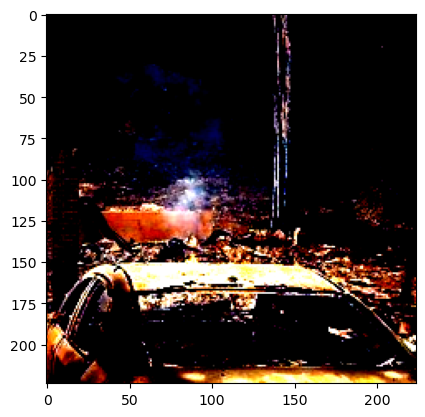

In [66]:
import matplotlib.pyplot as plt
import numpy as np
img = item1[0].permute((1,2,0)) # get just the image (not the label) with the channels as the last idx

img = img.cpu().numpy() 
print(img.shape)

#show the image
plt.imshow(img)
plt.show() 